# Agent-based credit risk modeling

Summer School Bayonne July 2024<br>
Author:      Dr. Mario Gellrich<br><br>
Last update: 2024-07-01

<p>The term 'credit risk' refers to the risk that a lender may not receive the owed principal and interest. The principal is the amount a consumer borrowed and have to pay back. Interest is what the lender charges for lending the money. The credit risk of a borrower can be measured by the five Cs (see: <a>https://www.openriskmanual.org/wiki/Five_Cs_Of_Credit_Analysis</a>): capacity, capital, character, colletaral, conditions. Based on this information a credit score can be calculated for every consumer. A credit score is one indicator that lenders use to asses how likely it is that a borrower is to default. To compensate for the credit risk, consumers with lower credit scores are usually charged higher interest rates on loans than consumers with higher credit scores.</p>

<p>The agent-based model (ABM) provided in this Jupyter notebook is used to explore the role of different parameters like the number of agents and loan term on the credit risk. It contains a Lender class, a Borrower class and a CreditModel class. The model contains different time steps corresponding to the number of month in which the loan must be repayed (the loan term). The model also contains different borrower agents. Each borrower has a credit score ranging from 50 to 100. The interest rate depends on the credit risk score. If the credit risk score is high, the interest rate is low and vice versa.</p>
    
<p>At the beginning, each borrower asks for a random amount of money (the principle) between 50,000 and 500,000 USD. The model steps correspond to the number of months in which the loan must be repayed. At each model step, the borrower must repay the monthly loan. As in practise, the monthly payment remains the same throughout the loan term, but the allocation between principal and interest changes over time. At the beginning, a larger portion of the payment goes towards interest, while towards the end, a larger portion goes towards the principal. Sometimes a borrower cannot repay the monthly loan. If this happens, the borrower must repay the monthly rate owed in the next model step. If a borrower cannot repay the loan for three consecutive months, this borrower is removed from the model, and the remaining loan is considered as defaulted.</p>

## Model description

## Libraries and settings

In [1]:
# Libraries
import os
import json
import openai
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from mesa import Agent, Model
from mesa.time import RandomActivation

# Set random seed
random.seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# OpenAI API key
credentials = json.loads(Path('../credentials.json').read_text())['openai']
openai.api_key = credentials.get('api_key')

# Show current working directory
print(os.getcwd())

u:\Lektionen\Summerschool_FS2024\Agent_Based_Credit_Risk_Modeling


## Example loan calculation

See: https://www.calculator.net/loan-calculator.html

In [2]:
# Input
# p = loan amount (principle)
# r = monthly interest rate
# y = number of years
# n = total number of months

p = 100000
r = 0.05 / 12
y = 30
n = y*12

# Monthly loan
m = p * r * (1 + r)**n / ((1 + r)**n - 1)

# Summary of results
print(f"Principle: {p:.0f} USD")
print(f"Loan term: {y} years ({y*12} months)")
print(f"Interest rate: {r*12*100:.2f} %")
print(f"Monthly loan: {m:.2f} USD")
print(f"Annually loan: {m*12:.2f} USD")
print(f"Total interest over {y} years: {m*n - p:.2f} USD")
print(f"Principle plus interest over {y} years: {m*n:.2f} USD")

Principle: 100000 USD
Loan term: 30 years (360 months)
Interest rate: 5.00 %
Monthly loan: 536.82 USD
Annually loan: 6441.86 USD
Total interest over 30 years: 93255.78 USD
Principle plus interest over 30 years: 193255.78 USD


## Let gpt-3.5-turbo create a function to calculate the monthly loan

In [3]:
# Function to generate a function code using GPT-3.5 Turbo
def generate_function_code(description):
    prompt = f"Write a Python function that does the following: {description}"
    
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    
    return response.choices[0].message['content'].strip()

# Example description for the function
description = """Calculate the monthly loan payment for a given loan amount, 
                 interest rate, and loan term in years. Test the function with
                 a loan amount of $100,000, an interest rate of 5%, and a loan term
                 of 30 years."""

# Generate the function code
function_code = generate_function_code(description)
print("Generated function code:")
print(function_code)

Generated function code:
Here is a Python function that calculates the monthly loan payment based on the loan amount, interest rate, and loan term:

```python
def calculate_monthly_payment(loan_amount, annual_interest_rate, loan_term_years):
    monthly_interest_rate = annual_interest_rate / 100 / 12
    number_of_payments = loan_term_years * 12
    monthly_payment = loan_amount * monthly_interest_rate * (1 + monthly_interest_rate) ** number_of_payments / ((1 + monthly_interest_rate) ** number_of_payments - 1)
    
    return monthly_payment

# Test the function with a loan amount of $100,000, an interest rate of 5%, and a loan term of 30 years
loan_amount = 100000
interest_rate = 5
loan_term = 30

monthly_payment = calculate_monthly_payment(loan_amount, interest_rate, loan_term)
print(f"The monthly loan payment is: ${monthly_payment:.2f}")
```

When you run this script, it will output the monthly loan payment based on the input loan amount, interest rate, and loan term.


## Basic agent-based credit risk model

### Lender class

In [4]:
class Lender_(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    # Calculate interest rate depending on the borrowers credit score
    def calculate_interest_rate(self, borrower):
        interest_rate = 0.04 + ((100 - borrower.credit_score) * 0.0004)
        
        return interest_rate

### Borrower class

In [5]:
class Borrower_(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.credit_score = random.randint(50, 100)
        self.loan_amount = 100
        self.principle = self.loan_amount
    
    # Display balance
    def display_balance(self):
        print(f"Borrower {self.unique_id + 1}: Balance at step 0: {self.loan_amount:.2f}.- USD")

    # Loan payments per step (in this example, only the interest is payed)
    def step(self):
        repayment_amount = self.principle * self.interest_rate
        self.loan_amount -= repayment_amount

### CreditModel class

In [6]:
class CreditModel_(Model):
    def __init__(self, num_borrowers):
        self.num_agents = num_borrowers
        self.schedule = RandomActivation(self)
        self.step_number = 0

        for i in range(self.num_agents):
            a = Borrower_(i, self)
            self.schedule.add(a)

        # Instance of Lender class
        self.lender = Lender_(0, self)

        # Calculate and show interest rates of borrower agents
        self.interest_rate()

    def interest_rate(self):
        borrowers = self.schedule.agents
        for borrower in borrowers:
            borrower.interest_rate = self.lender.calculate_interest_rate(borrower)
            print(f"Interest rate of Borrower {borrower.unique_id + 1}: {borrower.interest_rate:.2%}")

    def step(self):
        self.step_number += 1
        self.schedule.step()


### Calling the Borrower, Lender and CreditModel classes

In [7]:
# Create a model with three agents
print("Interest rates of borrowers:")
model = CreditModel_(3)

# Print initial balance of agents
print("\nBalance of borrowers:")
for agent in model.schedule.agents:
    agent.display_balance()

# Run the model for five steps
for i in range(5):
    model.step()

    # Print the balance of each agent
    for agent in model.schedule.agents:
        print(f"Borrower {agent.unique_id + 1}: Balance at step {model.step_number}: {agent.loan_amount:.2f}.- USD")


Interest rates of borrowers:
Interest rate of Borrower 1: 4.40%
Interest rate of Borrower 2: 5.72%
Interest rate of Borrower 3: 5.96%

Balance of borrowers:
Borrower 1: Balance at step 0: 100.00.- USD
Borrower 2: Balance at step 0: 100.00.- USD
Borrower 3: Balance at step 0: 100.00.- USD
Borrower 1: Balance at step 1: 95.60.- USD
Borrower 2: Balance at step 1: 94.28.- USD
Borrower 3: Balance at step 1: 94.04.- USD
Borrower 1: Balance at step 2: 91.20.- USD
Borrower 2: Balance at step 2: 88.56.- USD
Borrower 3: Balance at step 2: 88.08.- USD
Borrower 1: Balance at step 3: 86.80.- USD
Borrower 2: Balance at step 3: 82.84.- USD
Borrower 3: Balance at step 3: 82.12.- USD
Borrower 1: Balance at step 4: 82.40.- USD
Borrower 2: Balance at step 4: 77.12.- USD
Borrower 3: Balance at step 4: 76.16.- USD
Borrower 1: Balance at step 5: 78.00.- USD
Borrower 2: Balance at step 5: 71.40.- USD
Borrower 3: Balance at step 5: 70.20.- USD


## Extended agent-based credit risk model

### Lender class

In [8]:
class Lender(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    # Calculate interest rate
    def calculate_interest_rate(self, credit_score):
        interest_rate = 0.04 + ((100 - credit_score) * 0.0004)
        
        return interest_rate

# Example call of the Lender class
l1 = Lender(1,1)
l1.calculate_interest_rate(85)

0.046

### Borrower class

In [9]:
class Borrower(Agent):
    def __init__(self, unique_id, model, num_months, prob):
        super().__init__(unique_id, model)
        self.loan_amount = random.choice(list(range(50000, 500000, 5000)))
        self.num_months = num_months
        self.credit_score = random.randint(50, 100)
        self.monthly_loan = self.calculate_loan_amount()[0]
        self.balance = self.calculate_loan_amount()[1]
        self.payed_off = False
        self.time_to_repay = self.num_months
        self.defaulted = []
        self.removed = 0
        self.prob = self.probability_of_payment(prob)
    
    # Method to calculate the loan amount
    def calculate_loan_amount(self):
        lender = Lender(1,1)
        credit_score = self.credit_score
        # Here, the interest rate is calculated using the Lender class
        interest_rate = lender.calculate_interest_rate(credit_score)
        r = interest_rate / 12
        numerator = self.loan_amount * r * (1 + r)**self.num_months
        denominator = (1 + r)**self.num_months - 1
        monthly_loan = numerator / denominator
        total_loan = monthly_loan * self.num_months
        return [monthly_loan, total_loan, interest_rate, r]
    
    # List to integrate a probability of monthly payments
    def probability_of_payment(self, p=0.10, length=20):
        result = []
        num_zeros = int(p * length)
        result.extend([0] * num_zeros)
        result.extend([1] * (length - num_zeros))
        random.shuffle(result)
        return result
    
    # Method which defines the agents payments per step
    def step(self):
        # Make a payment or not (X% probability of 'no payment')
        payment = random.choice(self.prob)
        
        # If monthly loan is payed  ...
        if payment == 1:

            # Check whether the last payment has been made
            if sum(self.defaulted) == 0:
                self.monthly_loan = self.calculate_loan_amount()[0]
                self.defaulted = []
                self.balance -= self.monthly_loan
                self.payed_off = True
                self.time_to_repay -= 1

            # Check whether the last payment has been made and (if not) increase the monthly loan
            elif sum(self.defaulted) == 1:
                self.monthly_loan = self.calculate_loan_amount()[0] * 2
                self.defaulted = []
                self.balance -= self.monthly_loan
                self.payed_off = True
                self.time_to_repay -= 1

            # Check whether the last two payments has been made and (if not) increase the monthly loan
            elif sum(self.defaulted) == 2:
                self.monthly_loan = self.calculate_loan_amount()[0] * 3
                self.defaulted = []
                self.balance -= self.monthly_loan
                self.payed_off = True
                self.time_to_repay -= 1

            else:
                pass

        # If monthly loan is not payed ...
        else:
            # Increase the 'defaulted' counter
            self.defaulted.append(1)

            # Update balance, payed_off flag and time_to_repay
            if sum(self.defaulted) < 3:
                self.payed_off = False
                self.time_to_repay -= 1
            
            # Remove the agent from the model
            elif sum(self.defaulted) >= 3:
                self.model.remove_agent(self)
                self.removed = 1
            
            else:
                pass

# Example call of the Borrower class
b1 = Borrower(unique_id=1, model=1, num_months=3, prob=0.10)
b1.calculate_loan_amount()


[75676.01022529276, 227028.03067587828, 0.054, 0.0045]

### CreditModel class

In [10]:
class CreditModel(Model):

    # Method to initialize the class instance (= constructor)
    def __init__(self, num_borrowers, num_months, prob):
        self.num_borrowers = num_borrowers
        self.num_months = num_months
        self.schedule = RandomActivation(self)
        self.step_number = 0
        self.prob = prob
        
        # Create agents with unique IDs
        for i in range(self.num_borrowers):
            borrower = Borrower(i, self, num_months, prob)
            self.schedule.add(borrower)

        # Create an empty data frame to store results
        self.results_df = pd.DataFrame(columns=['Borrower', 
                                                'Step', 
                                                'Principle', 
                                                'Credit_Score', 
                                                'Interest_Rate', 
                                                'Balance', 
                                                'Payed_Off'])

        # Store the initial state in the data frame
        for agent in self.schedule.agents:
            new_row = {'Borrower': agent.unique_id,
                       'Step': self.step_number,
                       'Principle': agent.loan_amount,
                       'Credit_Score': agent.credit_score,
                       'Interest_Rate': agent.calculate_loan_amount()[2],
                       'Balance': round(agent.balance, 2),
                       'Payed_Off': agent.payed_off}
            self.results_df = pd.concat([self.results_df, 
                                         pd.DataFrame(new_row, index=[0])], 
                                        ignore_index=True)
            
    # Schedule agents
    def step(self):
        self.step_number += 1
        self.schedule.step()

        # Store the model results in a data frame
        for agent in self.schedule.agents:
            new_row = {'Borrower': agent.unique_id,
                       'Step': self.step_number,
                       'Principle': agent.loan_amount,
                       'Credit_Score': agent.credit_score,
                       'Interest_Rate': agent.calculate_loan_amount()[2],
                       'Balance': round(agent.balance, 2),
                       'Payed_Off': agent.payed_off}
            self.results_df = pd.concat([self.results_df, 
                                         pd.DataFrame(new_row, index=[0])], 
                                        ignore_index=True)

    # Method to remove agents
    def remove_agent(self, agent):
        self.schedule.remove(agent)

# Example call of the CreditModel class
cm1 = CreditModel(num_borrowers = 2, num_months = 3, prob = 0.05)
for i in range(3):
    cm1.step()
cm1.results_df


,Borrower,Step,Principle,Credit_Score,Interest_Rate,Balance,Payed_Off
0,0,0,425000,67,0.0532,428773.89,False
1,1,0,390000,57,0.0572,393723.89,False
2,0,1,425000,67,0.0532,285849.26,True
3,1,1,390000,57,0.0572,262482.60,True
4,0,2,425000,67,0.0532,142924.63,True
5,1,2,390000,57,0.0572,131241.30,True
6,0,3,425000,67,0.0532,0.00,True
7,1,3,390000,57,0.0572,-0.00,True


### Model parameter settings

In [11]:
# Model parameters
# num_borrowers:   number of borrower agents in the model
# num_months:      credit period in months
# prob_defaulted:  probablity that a borrower cannot repay the monthly loan

num_borrowers = 25
num_months = 360
prob_defaulted = 0.10

### Model run

In [12]:
# Model
model = CreditModel(num_borrowers=num_borrowers, 
                    num_months=num_months, 
                    prob=prob_defaulted)

# Run the model for multiple timesteps
for i in range(num_months):
    model.step()

### Analysis of model results

#### Data frame with model results per step

In [13]:
df = model.results_df
df

,Borrower,Step,Principle,Credit_Score,Interest_Rate,Balance,Payed_Off
0,0,0,495000,93,0.0428,879769.41,False
1,1,0,185000,86,0.0456,339830.90,False
2,2,0,105000,98,0.0408,182210.70,False
3,3,0,120000,68,0.0528,239355.35,False
4,4,0,360000,51,0.0596,773687.73,False
...,...,...,...,...,...,...,...
7694,17,360,270000,69,0.0524,0.00,True
7695,19,360,90000,92,0.0432,892.88,False
7696,20,360,305000,85,0.0460,0.00,True
7697,22,360,495000,74,0.0504,0.00,True


#### Line charts with model results per step

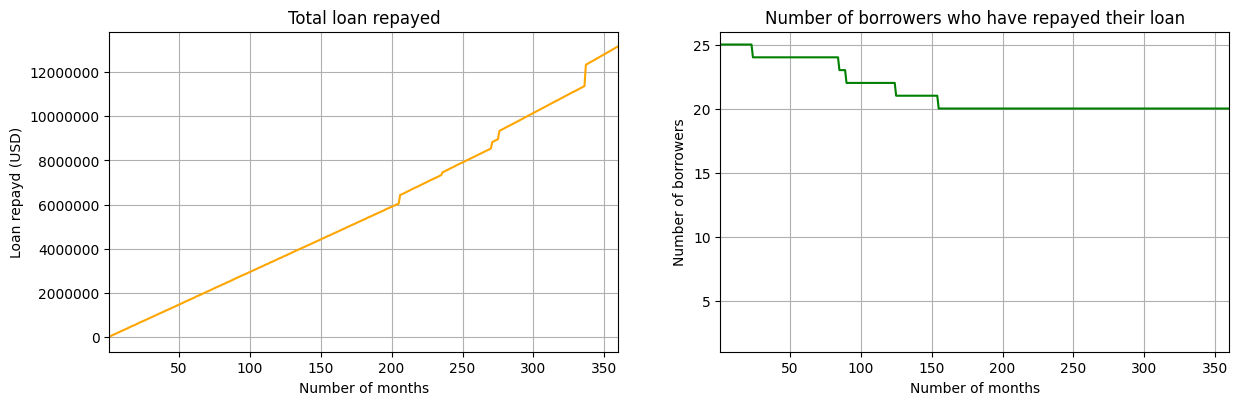

In [14]:
# Pivot tables with balances and borrowers
tab_balance = pd.pivot_table(df[['Step', 'Balance']],
                            index=['Step'],
                            values=['Balance'],
                            aggfunc=np.sum)

tab_borrowers = pd.pivot_table(df[['Step', 'Borrower']],
                                index=['Step'],
                                values=['Borrower'],
                                aggfunc='count')

# Line chart (balances)
tab_balance_sorted = tab_balance.sort_index(ascending=False)
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=False)
ax[0].plot(tab_balance.index, tab_balance_sorted['Balance'], label="Repaid", color="orange")
ax[0].set_xlim(1, num_months)
ax[0].set_xlabel('Number of months')
ax[0].set_ylabel('Loan repayd (USD)')
ax[0].set_title('Total loan repayed')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].grid()

# Line chart (borrowers)
tab_borrowers_sorted = tab_borrowers.sort_index(ascending=False)
ax[1].plot(tab_borrowers.index, tab_borrowers['Borrower'], label="Repaid", color="green")
ax[1].set_xlim(1, num_months)
ax[1].set_ylim(1, num_borrowers + 1)
ax[1].set_xlabel('Number of months')
ax[1].set_ylabel('Number of borrowers')
ax[1].set_title('Number of borrowers who have repayed their loan')
ax[1].ticklabel_format(useOffset=False, style='plain')
ax[1].grid()

# Set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)

# Show plot
plt.show()

### Run multiple simulation models based on different model parameter settings

#### Function to run multiple simulation models and store the results

In [15]:
def simulation_models(num_borrowers, num_months, prob_defaulted):

    # Model
    model = CreditModel(num_borrowers=num_borrowers, 
                        num_months=num_months, 
                        prob=prob_defaulted)

    # Run the model for multiple timesteps
    for i in range(num_months):
        model.step()

    # Output
    df = model.results_df

    # Loan
    loan_amount = df.loc[df['Step'] == 0]['Principle'].sum()
    loan_plus_interest = df.loc[df['Step'] == 0]['Balance'].sum()

    # Mean credit score
    mean_credit_score = df.loc[df['Step'] == 0]['Credit_Score'].mean()

    # Mean interest rate
    mean_interest_rate = df.loc[df['Step'] == 0]['Interest_Rate'].mean()

    # Mean loan amount
    mean_loan_amount = df.loc[df['Step'] == 0]['Principle'].mean()

    # Defaulted loan
    defaulted_list = []
    idx = list(set(df['Borrower']))

    for i in idx:
        defaulted_list.append(df.loc[(df['Borrower'] == i)]['Balance'].iloc[-1])

    defaulted_loan_abs = sum(defaulted_list)
    defaulted_loan_rel = sum(defaulted_list) / loan_plus_interest

    # Defaulted borrowers
    defaulted_borrowers = tab_borrowers['Borrower'].iloc[0] - tab_borrowers['Borrower'].iloc[-1]

    # Profit (for simplification, the costs of investments are ignored here)
    profit_abs = (loan_plus_interest - defaulted_loan_abs) - loan_amount
    profit_rel = (profit_abs / loan_amount)

    # Return on investment (ROI)
    roi = profit_rel / (num_months / 12)

    # Save results as data frame
    df_exp = pd.DataFrame({ 'Borrowers': num_borrowers,
                            'Months': num_months,
                            'Mean_Credit_Score': int(mean_credit_score),
                            'Mean_Interest_Rate': mean_interest_rate,
                            'Mean_Loan_Amount': int(mean_loan_amount),
                            'Total_Loan_Amount': int(loan_amount),
                            'Total_Loan_Amount_plus_Interest': int(loan_plus_interest),
                            'Borrowers_Defaulted': defaulted_borrowers,
                            'Defaulted_Loan': defaulted_loan_rel, 
                            'ROI': roi}, index=[0])

    return df_exp

#### Run multiple simulations

In [16]:
# Initialize df_sim as an empty data frame
df_sim = pd.DataFrame()

# List with the number of months for simulation
param_month = [num * 36 for num in range(1, 10 + 1)]
print("Number of months in the simulation:", param_month)

# Loop
for i in param_month:
    df_res = simulation_models(num_borrowers=25, 
                               num_months=i,
                               prob_defaulted=0.10)
    
    df_sim = pd.concat([df_sim, df_res.reindex(df_res.index)], axis=0)

# Result
df_sim

Number of months in the simulation: [36, 72, 108, 144, 180, 216, 252, 288, 324, 360]


,Borrowers,Months,Mean_Credit_Score,Mean_Interest_Rate,Mean_Loan_Amount,Total_Loan_Amount,Total_Loan_Amount_plus_Interest,Borrowers_Defaulted,Defaulted_Loan,ROI
0,25,36,74,0.050256,281200,7030000,7598952,5,0.005757,0.024903
0,25,72,75,0.049648,253400,6335000,7332932,5,0.019509,0.022491
0,25,108,75,0.049792,238800,5970000,7377830,5,0.024340,0.022860
0,25,144,80,0.047632,284800,7120000,9361202,5,0.046176,0.021172
0,25,180,71,0.051264,262600,6565000,9406940,5,0.063739,0.022771
0,25,216,75,0.049712,252000,6300000,9542720,5,0.080158,0.021850
0,25,252,70,0.051712,255400,6385000,10498327,5,0.093382,0.023366
0,25,288,75,0.049824,318000,7950000,13608469,5,0.124507,0.020776
0,25,324,77,0.048944,296800,7420000,13567540,5,0.100796,0.023859
0,25,360,75,0.049904,320600,8015000,15439241,5,0.082152,0.025601


#### Defaulted loan versus credit period in months

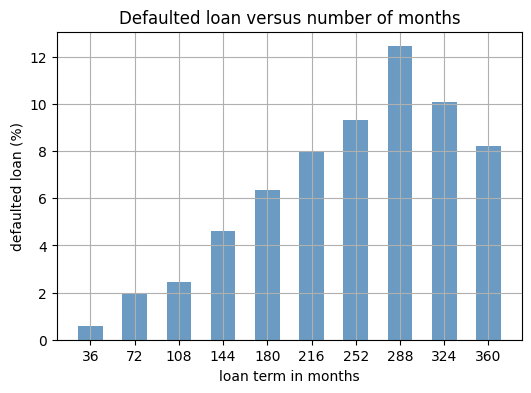

In [17]:
# Bar chart
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(df_sim['Months'],
       df_sim['Defaulted_Loan']*100, 
       align='center',
       color='steelblue', 
       alpha=0.8,
       width=20)
ax.set_title('Defaulted loan versus number of months')
ax.set_xlabel('loan term in months')
ax.set_ylabel('defaulted loan (%)')
ax.set_xticks(df_sim['Months'])
ax.set_xticklabels(df_sim['Months']) 
ax.grid()

# Show graph
plt.show()

#### ROI versus defaulted loan

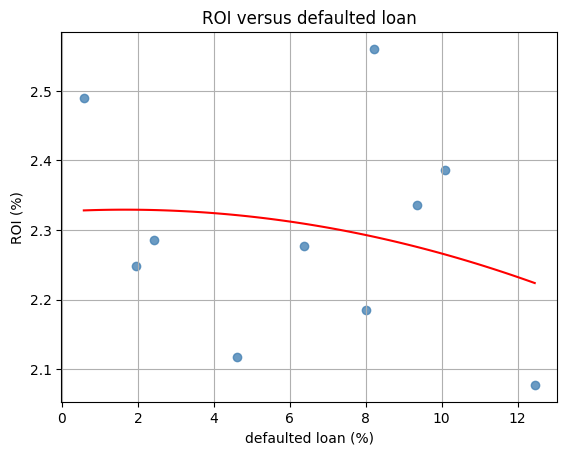

In [18]:
# Scatter plot
x = df_sim['Defaulted_Loan']*100
y = df_sim['ROI']*100

# Fit a function
fit = np.polyfit(x, y, 2)
p = np.poly1d(fit)

# Scatterplot
plt.scatter(x, y, color='steelblue', alpha=0.8)

# Create x values for the polynomial fit line
x_fit = np.linspace(x.min(), x.max(), 100)

# Create line showing the polynomial fit
plt.plot(x_fit, p(x_fit), 'r')

# Adding labels and title
plt.title('ROI versus defaulted loan')
plt.xlabel('defaulted loan (%)')
plt.ylabel('ROI (%)')
plt.grid()

# Displaying the scatter plot
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [19]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2024-07-04 15:56:34
Python Version: 3.10.14
-----------------------------------
